# studentsagainstdiscrimination

In [1]:
import json

# with open('StudentsAgainstDiscrimination/result.json') as f:
with open('sup/StudentsAgainstDiscrimination/result.json') as f:
    my_json = json.load(f)

In [2]:
import pandas as pd
my_keys = set()
emojis = set()
hashtags = set()
for message in my_json['messages']:
    if pd.to_datetime(message['date']) < pd.to_datetime("2024-08-06"):
        my_keys = my_keys.union(set(message.keys()))
        if ('reactions' in message) and (len(message['reactions']) >0):
            for rxn in message['reactions']:
                emojis.add(rxn['emoji'])
        if ('text_entities' in message) and (len(message['text_entities'] )> 0):
            hashtags = hashtags.union(set([i['text'] for i in message['text_entities'] if i['type']=='hashtag']))


In [3]:
import pandas as pd
from collections import defaultdict
import numpy as np

res_dict = defaultdict(list)
emoji_dict = defaultdict(list)
hashtag_dict = defaultdict(list)

for message in my_json['messages']:
    
    if (pd.to_datetime(message['date']) < pd.to_datetime("2024-08-06")) and (pd.to_datetime(message['date']) > pd.to_datetime("2024-01-01")) and (message['type']=='message'):
        for k, v in message.items():
            res_dict[k].append(str(v))
        text_plain = ''.join([i['text'] for i in message['text_entities'] if (i['type']!='hashtag') and (i['type']!='mention')])
        if ('photo' in message) and (pd.notnull(message['photo'])):
            text_plain = "media_image\n" + text_plain
        if ('media_type' in message):
            if message['media_type'] == 'video_file':
                text_plain = "media_video\n" + text_plain
            if message['media_type'] == 'voice_message':
                text_plain = "media_audio\n" + text_plain
        res_dict['text_plain'].append(text_plain)
        un_list = [i for i in my_keys if i not in message]
        for i in un_list:
            res_dict[i].append(np.nan)
        
        temp_emojis = dict()
        emoji_dict['id'].append(message['id'])
        if ('reactions' in message) and (len(message['reactions']) > 0):
            temp_emojis = {i['emoji']:i['count'] for i in message['reactions']}
        
        for k, v in temp_emojis.items():
            emoji_dict[k].append(v)
        un_emojis = [i for i in emojis if i not in temp_emojis]
        for i in un_emojis:
            emoji_dict[i].append(np.nan)
        
        temp_hashs = set()
        hashtag_dict['id'].append(message['id'])
        if ('text_entities' in message) and (len(message['text_entities']) > 0):
            for j in [i['text'] for i in message['text_entities'] if i['type']=='hashtag']:
                if j not in temp_hashs:
                    temp_hashs.add(j)
                    hashtag_dict[j].append(1)
        un_hashs = [i for i in hashtags if i not in temp_hashs]
        for i in un_hashs:
            hashtag_dict[i].append(np.nan)

In [4]:
result_df = pd.DataFrame(res_dict)
result_df = result_df[result_df['text_plain'].apply(len)>0].reset_index(drop=True)
result_df['id'] = result_df['id'].astype(int)
result_df['date'] = pd.to_datetime(result_df['date'])

emoji_df = pd.DataFrame(emoji_dict)
emoji_df['id'] = emoji_df['id'].astype(int)

hashtag_df = pd.DataFrame(hashtag_dict)
hashtag_df['id'] = hashtag_df['id'].astype(int)


result_df['num_reactions'] = result_df['id'].map(emoji_df.set_index('id').sum(axis=1).to_dict())

result_df['Reactions'] = result_df['id'].map(emoji_df.set_index('id').apply(lambda x: "Reactions: " + " ".join([i+str(int(v)) for i, v in x.sort_values(ascending=False).items() if pd.notna(v)]), axis=1))
result_df['Text_Emotion'] = (result_df['text_plain'] + " " + result_df['Reactions']).str.strip()

result_df['image_address'] = result_df['photo'].apply(lambda x: 'sup/StudentsAgainstDiscrimination/' + x if pd.notnull(x) else np.nan)

result_df['weights'] = np.sqrt(result_df['num_reactions']+1).astype(int)

In [5]:
from bnlp import NLTKTokenizer, BengaliCorpus
from bangla_stemmer.stemmer.stemmer import BanglaStemmer
import os
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from contextlib import redirect_stdout

snowball_stemmer = nltk.stem.SnowballStemmer('english')

stemmer = BanglaStemmer()

# bnltk_tokenizer = NLTKTokenizer()
twt_tokenizer = TweetTokenizer()

ignore_words = stopwords.words('english') + BengaliCorpus.stopwords + list(BengaliCorpus.punctuations) + ['➡', "", "click", "..", "..."]

def process_texts(x):
    x = x.lower().replace("।", "")
    
    nltk_tokens = twt_tokenizer.tokenize(x)
    filtered_nltk_tokens = [i for i in nltk_tokens if (i not in ignore_words) and (len(i.strip())> 1)]
    # filtered_tokens = [i for i in stemmed_tokens if i not in BengaliCorpus.stopwords]
    stemmed_tokens = [snowball_stemmer.stem(i) for i in filtered_nltk_tokens]
    # x = " ".join(stemmed_tokens)
    
    
    # tokens = bnltk_tokenizer.word_tokenize(x)
    
    with open(os.devnull, 'w') as f:
        with redirect_stdout(f):
            stemmed_tokens = [stemmer.stem(i) for i in stemmed_tokens]
    
    return [i for i in stemmed_tokens if len(i) >0]



result_df['documents'] = result_df['text_plain'].apply(process_texts)


result_df['documents']=result_df['documents'].apply(lambda x: [i for i in x if len(i)>1])


punkt not found. downloading...


[nltk_data] Downloading package punkt_tab to /home/fahim/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
/home/fahim/miniconda3/envs/llm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, CoherenceModel


result_df_subset = result_df[result_df['documents'].apply(len)>0].reset_index(drop=True)

dictionary = Dictionary(result_df_subset['documents'])


weighted_corpus = []
for i, text in enumerate(result_df_subset['documents']):
    bow = dictionary.doc2bow(text)
    weighted_bow = []
    for word_id, count in bow:
        weighted_bow.append((word_id, count * result_df_subset['weights'].iloc[i]))
    weighted_corpus.append(weighted_bow)

lda_model = LdaModel(weighted_corpus, 3, id2word=dictionary)

print(lda_model.log_perplexity(weighted_corpus))

cohere_model = CoherenceModel(model=lda_model, corpus=weighted_corpus, dictionary=dictionary, coherence='u_mass')
print(cohere_model.get_coherence())
lda_model.print_topics()

-7.7460876136615315
-2.694653485213545


[(0,
  '0.024*"media_video" + 0.012*"ছাত্র" + 0.010*"শিক্ষার্থী" + 0.010*"পুলিশ" + 0.010*"এক" + 0.010*"আন্দোলন" + 0.007*"media_imag" + 0.006*"হয়" + 0.006*"বিশ্ববিদ্যালয়" + 0.006*"জুলা"'),
 (1,
  '0.019*"media_imag" + 0.010*"আপনা" + 0.008*"হয়" + 0.007*"ছাত্র" + 0.007*"ঢাকা" + 0.006*"আন্দোলন" + 0.006*"সকল" + 0.006*"করুন" + 0.005*"ভাই" + 0.005*"সাথে"'),
 (2,
  '0.058*"media_imag" + 0.011*"ছাত্রলীগ" + 0.010*"আন্দোলন" + 0.010*"media_video" + 0.010*"ঢাকা" + 0.009*"ছাত্র" + 0.009*"হয়" + 0.009*"শিক্ষার্থী" + 0.006*"করুন" + 0.006*"বিশ্ববিদ্যালয়"')]

(array([19921., 19925., 19929., 19933., 19936., 19940.]),
 [Text(19921.0, 0, '2024-07-17'),
  Text(19925.0, 0, '2024-07-21'),
  Text(19929.0, 0, '2024-07-25'),
  Text(19933.0, 0, '2024-07-29'),
  Text(19936.0, 0, '2024-08-01'),
  Text(19940.0, 0, '2024-08-05')])

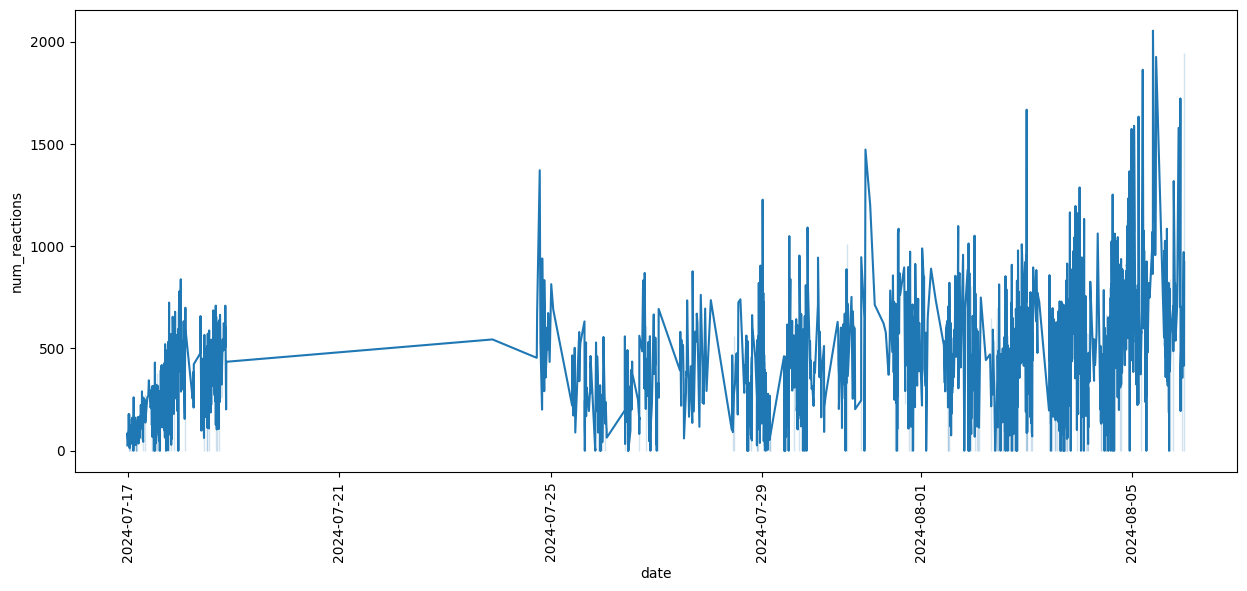

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,6))
sns.lineplot(x=result_df['date'], y=result_df['num_reactions'] )
plt.xticks(rotation=90,)

In [8]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Visualize the topics
pyLDAvis.enable_notebook()
p = gensimvis.prepare(lda_model, weighted_corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.005768 -0.076038       1        1  35.303190
0     -0.067876  0.042668       2        1  34.203636
1      0.073644  0.033370       3        1  30.493174, topic_info=               Term          Freq         Total Category  logprob  loglift
39       media_imag  26585.000000  26585.000000  Default  30.0000  30.0000
30      media_video  12079.000000  12079.000000  Default  29.0000  29.0000
91             আপনা   4228.000000   4228.000000  Default  28.0000  28.0000
6774             ৩৩   1246.000000   1246.000000  Default  27.0000  27.0000
1          ছাত্রলীগ   5443.000000   5443.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
30      media_video   1073.980510  12079.630091   Topic3  -5.5706  -1.2325
3               নাম    808.448553   3389.723749   Topic3  -5.8546  -0.2457
23    বিশ্ববিদ্যালয়    813.283165   4810.582986   Topic3  -5.8486  -0.5898
1          ছাত্রলীগ    783.690266   5443.540649   Topic3  -5.8857  -0.7505
104           পুলিশ    767.977432   5512.554131   Topic3  -5.9059  -0.7834

[310 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2885      2  0.968266     al
2885      3  0.017931     al
2886      1  0.027024  ambul
2886      2  0.945831  ambul
2886      3  0.027024  ambul
...     ...       ...    ...
416       2  0.669953   ২০২৪
416       3  0.142514   ২০২৪
6774      1  0.034487     ৩৩
6774      2  0.964836     ৩৩
6774      3  0.000802     ৩৩

[594 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [9]:
result_df_subset['text_plain'].str.contains('media_').sum()

2549

In [10]:
result_df_subset['text_plain'].str.contains('media_').sum()

2549

In [11]:
len(result_df_subset)

3370

In [12]:
len(result_df_subset)

3370

In [14]:
result_df.to_csv('myfolder/sad_main.csv', index=False)
emoji_df.to_csv('myfolder/sad_emoji.csv', index=False)

In [54]:
result_df['text_plain'].str.replace(r'media_\S+', "", regex=True).str.strip().str.split().apply(len).describe()

count    3371.000000
mean       17.492139
std        40.485828
min         0.000000
25%         0.000000
50%         6.000000
75%        17.000000
max       605.000000
Name: text_plain, dtype: float64

In [60]:
result_df['text_plain'].str.replace(r'media_\S+', "", regex=True).str.strip()[(result_df['text_plain'].str.replace(r'media_\S+', "", regex=True).str.strip().str.split().apply(len)<=1) & (result_df['text_plain'].str.replace(r'media_\S+', "", regex=True).str.strip().str.split().apply(len)>=1)][:50]

40                                                   গুজব
97                                                উফফফস!!
98                                                     ❤️
320     https://www.facebook.com/share/p/EMTNbVLk9Q1Yg...
349                                                    JU
365                                              জবিয়ানরা
370                                                    JU
385                                                 সাবাস
386                                                  ঢাবি
402                                                  SUST
422                                                    JU
431                                             Australia
448                                                  ঢাবি
468                                                  ঢাবি
475                                                  জাবি
478     Https://www.facebook.com/share/v/LZBHsKeL6xXhg...
485                                                  জাবি
643           

In [93]:
from PIL import Image, ImageOps

# img = Image.open(result_df['image_address'].iloc[5])
img = Image.open('sup/StudentsAgainstDiscrimination/photos/photo_2008@05-08-2024_23-24-29.jpg')

In [94]:
import io
import base64

buffer = io.BytesIO()

img.save(buffer, format='jpeg')

# buffer.seek(0)

base64.b64encode(buffer.getvalue()).decode('utf-8')

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCATUAs8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKQ9DilqN3AXkgfWgBM5HUZpd2O1czrnjTStERlmuFeYDPlpya8+1H4tXsjsLO2VFzwznk/hWM8RCDs2d+GyvE4hXhHQ9m3e+KC1eCf8LL8Ql93nwgf3TH/wDXrRsvizqcThby3SVe5T0

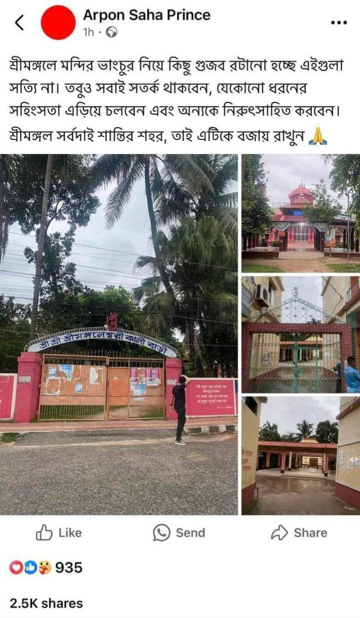

In [72]:
ImageOps.scale(img, 0.5)

In [11]:
result_df_subset['from'].value_counts()

from
বৈষম্যবিরোধী ছাত্র আন্দোলন    3370
Name: count, dtype: int64

In [120]:
emoji_df.set_index('id').dropna(how='all').sum(axis=1).sort_values()

id
508        2.0
1428       2.0
1435       3.0
1408       3.0
1426       4.0
         ...  
3544    1722.0
3385    1862.0
3423    1925.0
3558    1942.0
3417    2053.0
Length: 2549, dtype: float64

In [123]:
emoji_df.set_index('id').dropna(how='all').apply(lambda x: "Reactions: " + " ".join([i+str(int(v)) for i, v in x.sort_values(ascending=False).items() if pd.notna(v)]), axis=1)

id
3                       Reactions: 🔥25 👍1
4                       Reactions: ❤61 👍1
5           Reactions: 😱18 🤬3 👍2 ❤2 🤯1 🤔1
6                      Reactions: 🔥67 ❤19
7                 Reactions: ❤22 👍6 😢4 🔥1
                      ...                
3558            Reactions: ❤1755 🔥122 👍65
3560    Reactions: 👍577 🔥64 😢50 ❤35 😁6 🕊5
3561              Reactions: 👍334 ❤90 🔥10
3562           Reactions: 👍335 ❤61 🔥17 🥰3
3563       Reactions: ❤785 👍95 💯22 🔥15 🤗5
Length: 2549, dtype: object

In [86]:
# result_df_subset['from'].value_counts()
rel_cols = emoji_df.drop(columns=['id']).sum().sort_values(ascending=False)[:20].index.tolist()
emoji_df.drop(columns=['id']).sum().sort_values(ascending=False)[:20]

❤      453731.0
🔥      173308.0
👍      114250.0
😢       92675.0
🤬       82502.0
😁       64351.0
🤣       30542.0
😭       23844.0
🥰        6448.0
❤‍🔥      6394.0
👏        4033.0
🤡        3872.0
😡        3245.0
💔        2670.0
💩        2153.0
🫡        1458.0
👎        1434.0
🖕        1285.0
🤮        1205.0
💯        1007.0
dtype: float64

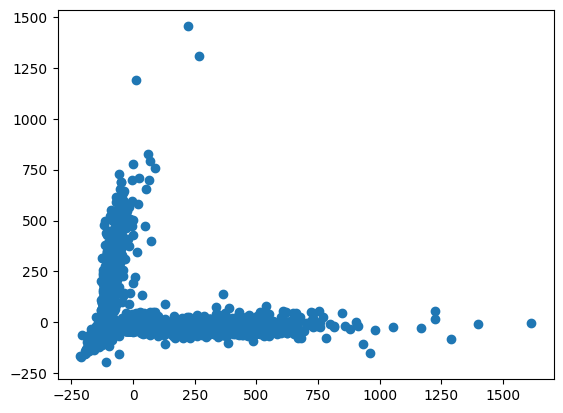

In [93]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)


res = pca.fit_transform(emoji_df.drop(columns=['id'])[rel_cols].fillna(0))

plt.scatter(x=res[:,0], y=res[:,1])
# res.shape

<Axes: >

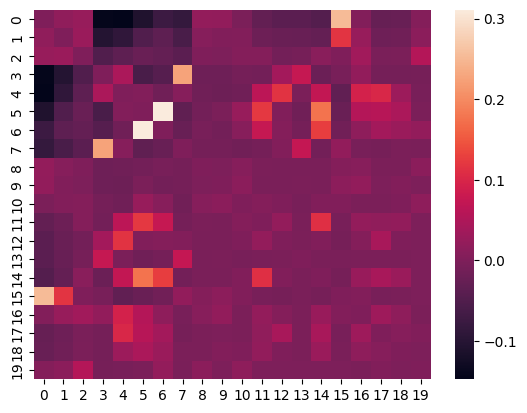

In [102]:
import numpy as np
# import seaborn as sns
my_res = emoji_df.drop(columns=['id'])[rel_cols].fillna(0).corr().values

np.fill_diagonal(my_res, 0)
sns.heatmap(my_res)
# np.fill
# sns.heatmap(emoji_df.drop(columns=['id'])[rel_cols].fillna(0).corr())
# fig, ax = plt.subplots()
# im = ax.imshow(emoji_df.drop(columns=['id'])[rel_cols].fillna(0).corr())

# ax.set_xticks(range(len(rel_cols)), labels=rel_cols,
#               rotation=45, ha="right", rotation_mode="anchor")
# ax.set_yticks(range(len(rel_cols)), labels=rel_cols)

# plt.show()

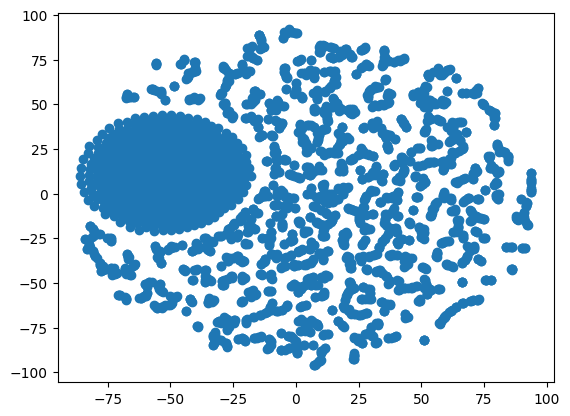

In [94]:
from sklearn.manifold import TSNE
t_sne_obj =  TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3)

res = t_sne_obj.fit_transform(emoji_df.drop(columns=['id'])[rel_cols].fillna(0))

plt.scatter(x=res[:,0], y=res[:,1])

In [13]:
with open('sup/StudentsAgainstDiscrimination_discuss/ChatExport_2025-06-29/result.json') as f:
    my_json = json.load(f)

In [15]:
len(my_json['messages'])

2554

In [33]:
from glob import glob
import pandas as pd
from collections import defaultdict
import hashlib

my_def_dict = defaultdict(list)
for file_addr in glob("sup/anitquotadu/photos/*"):
    my_def_dict['Address'].append(file_addr)
    my_def_dict['Name'].append(file_addr.split("/")[-1])
    with open(file_addr, 'rb') as f:
        my_def_dict['Hash'].append(hashlib.file_digest(f, 'sha256').hexdigest())

for file_addr in glob("sup/antiquotadu_discuss/photos/*"):
    my_def_dict['Address'].append(file_addr)
    my_def_dict['Name'].append(file_addr.split("/")[-1])
    with open(file_addr, 'rb') as f:
        my_def_dict['Hash'].append(hashlib.file_digest(f, 'sha256').hexdigest())

In [49]:
# len(my_list)
# my_list[0]
# pd.DataFrame(my_def_dict)['Hash'].duplicated().sum()
result_df['id'][result_df['image_address'].notna()]

4          7
5          8
12        15
13        16
18        21
        ... 
3364    3556
3365    3558
3366    3559
3368    3561
3369    3562
Name: id, Length: 2004, dtype: int64

In [53]:
from openai import OpenAI
from dotenv import load_dotenv
import json
import io
from PIL import Image, ImageOps
import base64

load_dotenv()

def count_openai_embedding_tokens(text: str) -> int:
    """Counts the number of tokens in a text string for OpenAI embedding models."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(text))
    return num_tokens


system_prompt = """You are an expert emotion analysis AI. Your task is to analyze the provided Telegram post and identify the **primary Ekman emotion** expressed.

The Ekman emotions you must choose from are:
- **Anger**: Feeling of antagonism provoked by ill-treatment or opposition.
- **Disgust**: Feeling of revulsion or strong disapproval aroused by something unpleasant or offensive.
- **Fear**: Unpleasant emotion caused by the belief that someone or something is dangerous, likely to cause pain, or a threat.
- **Happiness**: State of well-being and contentment; joy.
- **Sadness**: Emotional pain associated with, or characterized by, feelings of disadvantage, loss, despair, grief, helplessness, disappointment, and sorrow.
- **Surprise**: Feeling caused by something unexpected or unusual.

Please analyze the following telegram post and provide the primary Ekman emtion.

**If the primary emotion doesn't match any of the Ekman emotion then please provide the closest emotion outside the Ekman classification.

If no emotion could be found at all, then please return 'NA'."""

# system_prompt = """You are an expert emotion analysis AI. Your task is to analyze the provided Telegram post and identify the **primary Ekman emotion** expressed.

# The Ekman emotions you must choose from are:
# - **Anger**: Feeling of antagonism provoked by ill-treatment or opposition.
# - **Disgust**: Feeling of revulsion or strong disapproval aroused by something unpleasant or offensive.
# - **Fear**: Unpleasant emotion caused by the belief that someone or something is dangerous, likely to cause pain, or a threat.
# - **Happiness**: State of well-being and contentment; joy.
# - **Sadness**: Emotional pain associated with, or characterized by, feelings of disadvantage, loss, despair, grief, helplessness, disappointment, and sorrow.
# - **Surprise**: Feeling caused by something unexpected or unusual.

# Please analyze the following telegram post and return the dominant Ekman emotion in structured JSON format. If no emotion could be found, then please return 'N/A'. In addition to the emotion label, provide a short explanation for why this emotion was identified.

# Format your output as a valid JSON object with the following fields:
# {
#   "explanation": "<brief explanation (1-2 sentences) of which Ekman emotion is most dominant in the post>"
#   "emotion": "<one of: Anger, Disgust, Fear, Happiness, Sadness, Surprise, N/A>",
# }
# Ensure the output is strictly valid JSON."""


# response_format = {
#     "type": "json_schema",
#     "name": "ekman_emotion",
#     "schema": {
#         "type": "object",
#         "properties": {
#             "emotion": {
#                 "type": "string",
#                 "description": "The primary Ekman emotion expressed in the text.",
#                 "enum": [
#                     "Anger",
#                     "Disgust",
#                     "Fear",
#                     "Happiness",
#                     "Sadness",
#                     "Surprise",
#                     "NA",
#                 ],
#             }
#         },
#         "required": ["emotion"],
#         "additionalProperties": False,
#     },
#     "strict": True,
# }

tool = [
      {
        "type": "function",
        "function": {
          "name": "classify_ekman_emotion",
          "description": "Classify the dominant Ekman emotion from a Telegram post",
          "parameters": {
            "type": "object",
            "properties": {
              "explanation": {
                "type": "string",
                "description": "A brief explanation for which Ekman emotion is dominant"
              },
              "emotion": {
                "type": "string",
                # "enum": [
                #     "Anger",
                #     "Disgust",
                #     "Fear",
                #     "Happiness",
                #     "Sadness",
                #     "Surprise",
                #     "NA",
                # ],
                "description": "The dominant Ekman emotion"
              },
            },
            "required": ["explanation", "emotion"]
          }
        }
      }
    ]

my_texts = ["some text", "Doesn't look fun at all", "some other text", "This is so fun"]

# with open("my_test.jsonl", "w") as f:
#     for i, x in enumerate(my_texts):
#         json.dump(
#             {
#                 "custom_id": f"random_id{i}",
#                 "method": "POST",
#                 "url": "/v1/chat/completions",
#                 "body": {
#                     "model": "gpt-4.1-nano",
#                     "messages": [
#                         {"role": "system", "content": system_prompt},
#                         {"role": "user", "content": x},
#                     ],
#                 "tools":tool,
#                 "tool_choice":'required'
                
#                 },
#             },
#             f,
#         )
#         f.write("\n")

with open("StudentsAgainstDiscrimination_second_half.jsonl", "w") as f:
    for _, row in result_df.iloc[1686:].iterrows():
    # for i, x in enumerate(my_texts):
        if pd.isnull(row['image_address']):
          json.dump(
              {
                  "custom_id": f"students_against_discrimination_{row['id']}",
                  "method": "POST",
                  "url": "/v1/chat/completions",
                  "body": {
                      "model": "gpt-4.1-nano",
                      "messages": [
                          {"role": "system", "content": system_prompt},
                          {"role": "user", "content": row['Text_Emotion']},
                      ],
                  "tools":tool,
                  "tool_choice":'required'
                  
                  },
              },
              f,
          )
        else:
          img = Image.open(row['image_address'])
          
          min_size = min(img.size)
          buffer = io.BytesIO()
          if min_size > 128:
            img_small = ImageOps.scale(img, 128/min_size)
            img_small.save(buffer, format="jpeg")
          else:
            img.save(buffer, format='jpeg')



          encoded_img = base64.b64encode(buffer.getvalue()).decode("utf-8")
          
          json.dump(
              {
                  "custom_id": f"students_against_discrimination_{row['id']}",
                  "method": "POST",
                  "url": "/v1/chat/completions",
                  "body": {
                      "model": "gpt-4.1-nano",
                      "messages": [
                          {"role": "system", "content": system_prompt},
                          {"role": "user", "content": [{"type":"text", "text":row['Text_Emotion']},
                                                       {"type":"image_url", "image_url": {"url": f"data:image/jpeg;base64,{encoded_img}"}}]},
                      ],
                  "tools":tool,
                  "tool_choice":'required'
                  
                  },
              },
              f,
          )
        f.write("\n")

client = OpenAI()


In [54]:
batch_input_file = client.files.create(
    file=open("StudentsAgainstDiscrimination_second_half.jsonl", "rb"), purpose="batch"
)

print(batch_input_file)

FileObject(id='file-3AhkZF29KpoPAZRZtsSMLE', bytes=12080448, created_at=1751605726, filename='StudentsAgainstDiscrimination_second_half.jsonl', object='file', purpose='batch', status='processed', expires_at=None, status_details=None)


In [55]:
batch_input_file_id = batch_input_file.id

client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    metadata={"description": "StudentsAgainstDiscrimination emotion analysis v3 Second half"},
)

Batch(id='batch_686761e435648190a2ab5bc6c6af9c71', completion_window='24h', created_at=1751605732, endpoint='/v1/chat/completions', input_file_id='file-3AhkZF29KpoPAZRZtsSMLE', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1751692132, failed_at=None, finalizing_at=None, in_progress_at=None, metadata={'description': 'StudentsAgainstDiscrimination emotion analysis v3 Second half'}, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0))

In [58]:
# First half batch batch_68674ba7f78c81909feaad5c0f1f357c  output file: file-HjqBiEchixTZtamXGueveA

client.batches.retrieve('batch_686761e435648190a2ab5bc6c6af9c71')

Batch(id='batch_686761e435648190a2ab5bc6c6af9c71', completion_window='24h', created_at=1751605732, endpoint='/v1/chat/completions', input_file_id='file-3AhkZF29KpoPAZRZtsSMLE', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1751607582, error_file_id=None, errors=None, expired_at=None, expires_at=1751692132, failed_at=None, finalizing_at=1751606640, in_progress_at=1751605733, metadata={'description': 'StudentsAgainstDiscrimination emotion analysis v3 Second half'}, output_file_id='file-NRAEfoc2NYMtvpFfDSuXVu', request_counts=BatchRequestCounts(completed=1685, failed=0, total=1685))

In [59]:
# file_response = client.files.content('file-HjqBiEchixTZtamXGueveA')
file_response_2 = client.files.content('file-NRAEfoc2NYMtvpFfDSuXVu')

In [61]:
my_res_dict_2 = defaultdict(list)

for i in file_response_2.iter_lines():
    # print(i)
    # break
    my_res_dict_2['id'].append(int(json.loads(i)['custom_id'].split("_")[-1]))
    j = json.loads(json.loads(i)['response']['body']['choices'][0]['message']['tool_calls'][0]['function']['arguments'])
    try:
        my_res_dict_2['ekman_emotion'].append(j['emotion'])
    except:
        # print(j)
        # try:
        #     my_res_dict['ekman_emotion'].append(j[' emotion'])
        # except:
        #     # print(j)
        my_res_dict_2['ekman_emotion'].append('NA')
        
    my_res_dict_2['emotion_explanation'].append(j['explanation'])
    # print(j['emotion'], j['explanation'])

In [44]:
my_res_dict = defaultdict(list)

for i in file_response.iter_lines():
    # print(i)
    # break
    my_res_dict['id'].append(int(json.loads(i)['custom_id'].split("_")[-1]))
    j = json.loads(json.loads(i)['response']['body']['choices'][0]['message']['tool_calls'][0]['function']['arguments'])
    try:
        my_res_dict['ekman_emotion'].append(j['emotion'])
    except:
        # print(j)
        try:
            my_res_dict['ekman_emotion'].append(j[' emotion'])
        except:
            # print(j)
            my_res_dict['ekman_emotion'].append('NA')
        
    my_res_dict['emotion_explanation'].append(j['explanation'])
    # print(j['emotion'], j['explanation'])

In [63]:
# result_df.iloc[:5]['id']
result_df.merge(pd.concat([pd.DataFrame(my_res_dict), pd.DataFrame(my_res_dict_2)]), on='id')['ekman_emotion'].value_counts()

ekman_emotion
Happiness                                                                          1270
Anger                                                                               957
Sadness                                                                             445
NA                                                                                  316
Fear                                                                                210
Disgust                                                                             104
Surprise                                                                             58
Neutral                                                                               2
Mixed/Multiple emotions                                                               1
anticipation                                                                          1
anger                                                                                 1
Frustration       

In [64]:
# pd.DataFrame(my_res_dict).to_csv('StudentsAgainstDiscrimination_first_half_emotion.csv', index=False)
pd.DataFrame(my_res_dict_2).to_csv('StudentsAgainstDiscrimination_second_half_emotion.csv', index=False)

In [67]:
pd.concat([pd.DataFrame(my_res_dict), pd.DataFrame(my_res_dict_2)], ignore_index=True).to_csv('StudentsAgainstDiscrimination_emotion.csv', index=False)

In [22]:
from pydantic import BaseModel, Field

In [24]:
from enum import Enum

class EkmanEmotionEnum(Enum):
    ANGER = "Anger"
    DISGUST = "Disgust"
    FEAR = "Fear"
    HAPPINESS = "Happiness"
    SADNESS = "Sadness"
    SURPRISE = "Surprise"
    NA = "NA"

class EkmanEmotion(BaseModel):
    ekman_emotion:EkmanEmotionEnum

    

In [53]:
# help(Field)
client = OpenAI(timeout=900.0)


response = client.with_options(timeout=900.0).responses.create(
    model="o4-mini",
    input=[
        {
            "role": "system",
            "content": system_prompt,
        },
        {"role": "user", "content": "I am somewhat shocked."},
    ],
    # text_format=EkmanEmotion,
    text = {'format':response_format},
    service_tier='flex'
)

In [54]:
json.loads(response.output_text)['emotion']
# .output_parsed
# .ekman_emotion.value

'Surprise'

NameError: name 'result_df' is not defined